# Intro to tsfresh

more info on https://tsfresh.readthedocs.io

In [43]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import feature_extraction
from tsfresh.transformers import RelevantFeatureAugmenter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

## get data

run download_robot_execution_failures() once on login node with internet access

dataframe with columns robot id, time, and data from six sensors. In addition get dataframe with info on which robot id reported failure.

In [3]:
timeseries, y = load_robot_execution_failures()

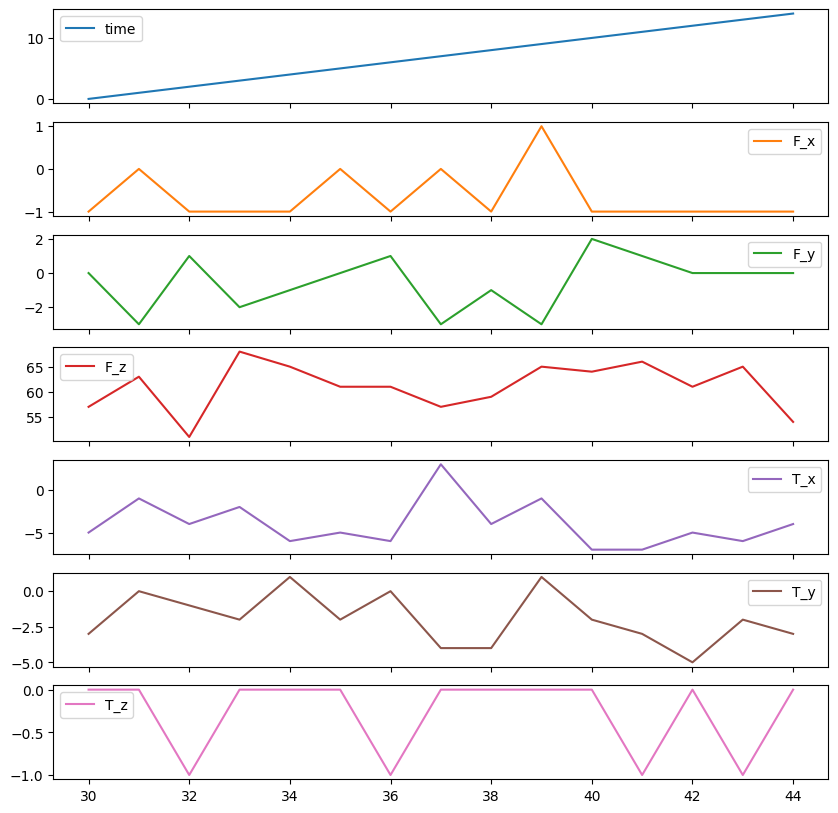

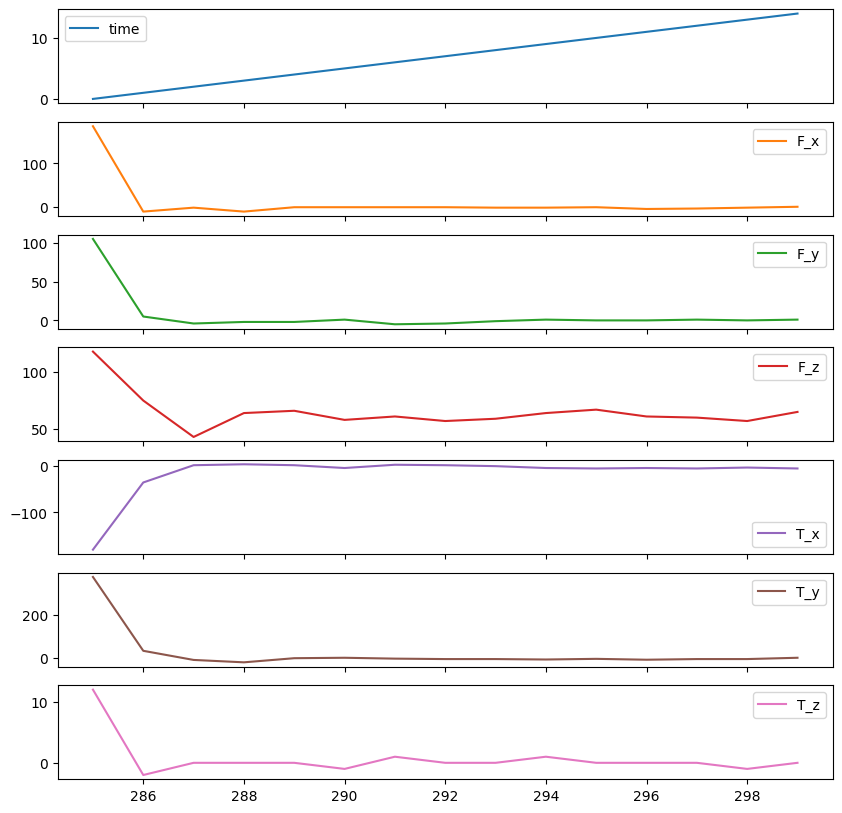

In [9]:
timeseries[timeseries['id'] == 3].iloc[:,1:].plot(subplots=True, sharex=True, figsize=(10,10)) # no failure
plt.show()
timeseries[timeseries['id'] == 20].iloc[:,1:].plot(subplots=True, sharex=True, figsize=(10,10)) # failure
plt.show()

## extract features

In [7]:
# get 1200 features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")
# check which ones are important
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

# OR all above steps in one
features_filtered_direct = extract_relevant_features(timeseries, y,
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 47.44it/s]
/scratch/c.c21013066/docker/envs/timeseries/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 68.46it/s]


In [14]:
extraction_settings = feature_extraction.ComprehensiveFCParameters()

X = extract_features(timeseries, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)
X_filtered = select_features(X, y)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 68.95it/s]


In [18]:
print(len(np.setdiff1d(X.columns,X_filtered.columns)),' columns dropped')
print(len(np.intersect1d(X.columns,X_filtered.columns)),' important columns remain')

4016  columns dropped
682  important columns remain


## classifier

try to learn from extracted features which robot failes

In [19]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.33)

classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_full_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_full_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        24
        True       1.00      0.83      0.91         6

    accuracy                           0.97        30
   macro avg       0.98      0.92      0.94        30
weighted avg       0.97      0.97      0.97        30



In [20]:
X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]

classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        24
        True       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## using the sklearn pipeline

In [23]:
X = pd.DataFrame(index=y.index) # create empty dataframe to be filled with features
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
# build pipeline
ppl = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
        ('classifier', RandomForestClassifier())
      ])
ppl.set_params(augmenter__timeseries_container=timeseries);

In [26]:
ppl.fit(X_train, y_train)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 102.56it/s]
/scratch/c.c21013066/docker/envs/timeseries/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_z__partial_autocorrelation__lag_7'
 'F_z__partial_autocorrelation__lag_8'
 'F_z__partial_autocorrelation__lag_9' ...
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='time',
                                          timeseries_container=      id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns])),
                ('classifier', RandomForestClassifier())])

In [28]:
y_pred = ppl.predict(X_test)
print(classification_report(y_test, y_pred))

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 463.93it/s]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         4

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [29]:
ppl.named_steps["augmenter"].feature_selector.relevant_features

['F_x__value_count__value_-1',
 'F_x__range_count__max_1__min_-1',
 'T_y__absolute_maximum',
 'F_x__mean_n_absolute_max__number_of_maxima_7',
 'F_y__mean_n_absolute_max__number_of_maxima_7',
 'F_x__root_mean_square',
 'F_x__abs_energy',
 'F_y__root_mean_square',
 'F_y__abs_energy',
 'T_y__standard_deviation',
 'T_y__variance',
 'F_y__absolute_maximum',
 'T_x__absolute_maximum',
 'F_x__absolute_maximum',
 'T_y__abs_energy',
 'F_x__fft_coefficient__attr_"abs"__coeff_1',
 'T_y__root_mean_square',
 'T_y__mean_n_absolute_max__number_of_maxima_7',
 'F_z__variance',
 'T_y__fft_coefficient__attr_"abs"__coeff_1',
 'F_x__cid_ce__normalize_True',
 'F_z__standard_deviation',
 'F_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'T_x__mean_n_absolute_max__number_of_maxima_7',
 'T_y__fft_coefficient__attr_"abs"__coeff_2',
 'F_x__partial_autocorrelation__lag_1',
 'F_x__autocorrelation__lag_1',
 'F_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
 'T_x__abs_energy',

## split test and train to save for later usage

In [32]:
df_ts_train = timeseries[timeseries["id"].isin(y_train.index)]
df_ts_test = timeseries[timeseries["id"].isin(y_test.index)]

In [33]:
ppl.set_params(augmenter__timeseries_container=df_ts_train);
ppl.fit(X_train, y_train);

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 102.56it/s]
/scratch/c.c21013066/docker/envs/timeseries/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [34]:
with open("pipeline.pkl", "wb") as f:
    pickle.dump(ppl, f)

In [35]:
with open("pipeline.pkl", "rb") as f:
    ppk = pickle.load(f)

In [36]:
ppl.set_params(augmenter__timeseries_container=df_ts_test);
y_pred = ppl.predict(X_test)
print(classification_report(y_test, y_pred))

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 457.02it/s]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         4

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



## controlling feature extraction

set of features is controlled by fc_parameters: settings.ComprehensiveFCParameters, settings.EfficientFCParameters, settings.MinimalFCParameters

In [45]:
feature_extraction.MinimalFCParameters()

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}